In [263]:
import scipy.special
from mplfinance.original_flavor import candlestick_ohlc  # pip install --upgrade mplfinance
import yfinance as yf  # pip install yfinance
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
from pandas.plotting import autocorrelation_plot
import pmdarima as pm
import hvplot

from dateutil.relativedelta import relativedelta  # working with dates with style
from scipy.optimize import minimize  # for function minimization
import statsmodels.formula.api as smf  # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product
from tqdm import tqdm_notebook

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")


In [264]:
# First import 2 datasets using get_price_data function and yfinance package
# Microsoft and Apple
def get_price_data(ticker):
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='1d', start='2017-1-1', end='2022-10-23')
    return tickerDf.iloc[:, :5]

In [265]:
# get price data (return pandas dataframe)
df_apple = get_price_data(ticker='AAPL')
df_msft = get_price_data(ticker='MSFT')

In [266]:
df_apple.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,27.092870,27.216870,26.849549,27.174757,115127600
2017-01-04,27.104565,27.258982,27.081169,27.144339,84472400
2017-01-05,27.120942,27.340868,27.095206,27.282377,88774400
2017-01-06,27.322152,27.645021,27.249624,27.586531,127007600
2017-01-09,27.595885,27.942151,27.593547,27.839207,134247600


In [267]:
df_msft.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,58.001816,58.048002,57.392146,57.807831,20694100
2017-01-04,57.715457,57.964868,57.382909,57.549183,21340000
2017-01-05,57.447571,57.881731,57.299772,57.549183,24876000
2017-01-06,57.549171,58.334354,57.308999,58.047993,19922900
2017-01-09,57.974095,58.269696,57.770874,57.863247,20382700


In [268]:
# check if index is a datetime object
df_apple.index.inferred_type == "datetime64"

True

In [269]:
#Visualize data using function
def linear_plot(data, plot_title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['Close'], linewidth=2.0)
    plt.title(plot_title, fontsize = 20)
    plt.show()


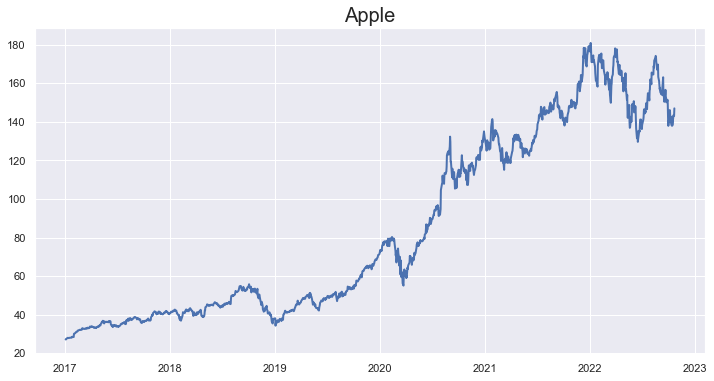

In [270]:
linear_plot(data=df_apple, plot_title='Apple')

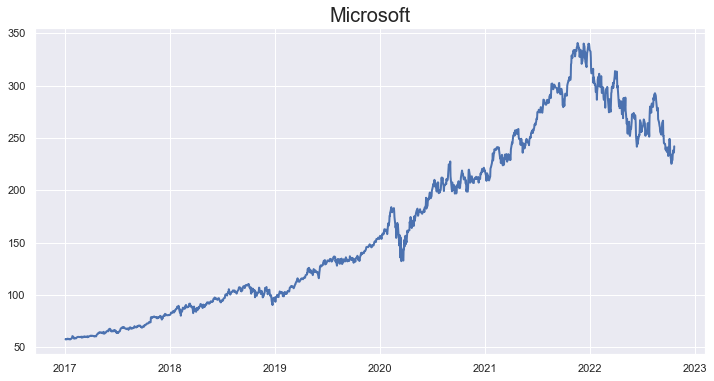

In [271]:
linear_plot(data=df_msft, plot_title='Microsoft')

<AxesSubplot:xlabel='Date'>

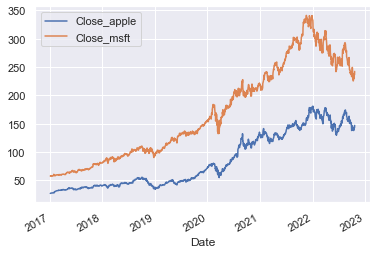

In [272]:
# Let's create one dataframe with closing prices only
df = pd.merge(df_apple['Close'], df_msft['Close'], left_index=True, right_index=True, suffixes= ('_apple', '_msft'))
# and plot the df without normalization first
df.plot()

In [273]:
#We can now plot them together after normalization to compare
first_row = df.iloc[0]
df_norm = df.divide(first_row, axis = 1)

In [274]:
df_norm.head()

,Close_apple,Close_msft
Date,,
2017-01-03,1.000000,1.000000
2017-01-04,0.998881,0.995526
2017-01-05,1.003960,0.995526
2017-01-06,1.015153,1.004154
2017-01-09,1.024451,1.000959


<AxesSubplot:xlabel='Date'>

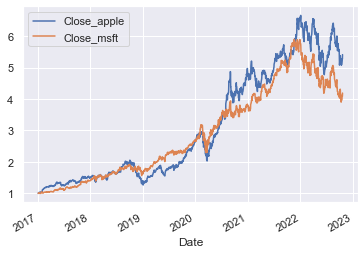

In [275]:
df_norm.plot()
# we can see that the growth is very similar

In [276]:
# Now we can decompose both of the stock values to see main information

import statsmodels as sm
from statsmodels.datasets import elec_equip, co2
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import matplotlib.pyplot as plt

In [277]:
df['Close_msft']

Date
2017-01-03     57.807831
2017-01-04     57.549183
2017-01-05     57.549183
2017-01-06     58.047993
2017-01-09     57.863247
                 ...    
2022-10-17    237.529999
2022-10-18    238.500000
2022-10-19    236.479996
2022-10-20    236.149994
2022-10-21    242.119995
Name: Close_msft, Length: 1462, dtype: float64

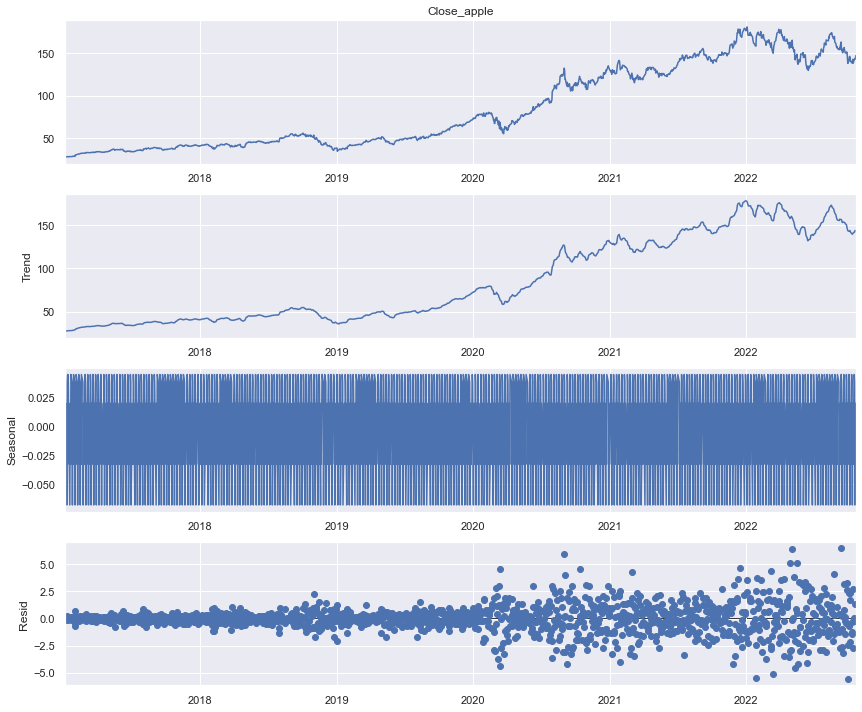

In [278]:
apple_decomposed = seasonal_decompose(df['Close_apple'],model='additive', period = 5)

apple_decomposed.plot()
plt.tight_layout(rect=[0, 0.5, 2, 3])
#period based on https://towardsdatascience.com/time-series-decomposition-and-statsmodels-parameters-69e54d035453
#253 since there are 253 days in a year, when the stock market is open
# or 5 since 5 days of the week is a working week

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

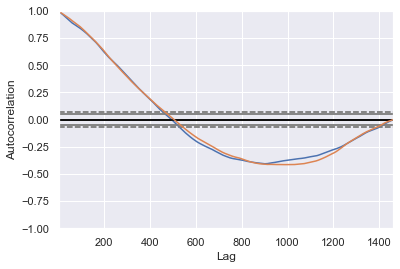

In [279]:
# And plot autocorrelation plot
autocorrelation_plot(df['Close_apple'])
autocorrelation_plot(df['Close_msft'])


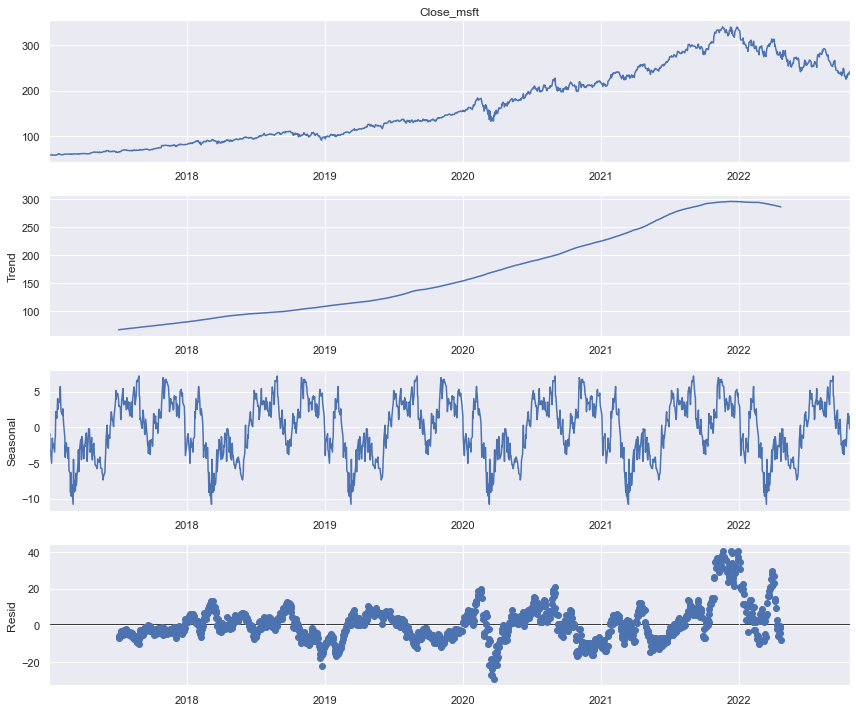

In [280]:
# same for microsoft
msft_decomposed = seasonal_decompose(df['Close_msft'],model='additive', period = 253)
msft_decomposed.plot()
plt.tight_layout(rect=[0, 0.5, 2, 3])


In [281]:
# function to test stationarity and plot the data
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

***Microsoft***

Results of Dickey-Fuller Test:
Test Statistic                   -1.040207
p-value                           0.738319
#Lags Used                        9.000000
Number of Observations Used    1452.000000
Critical Value (1%)              -3.434862
Critical Value (5%)              -2.863533
Critical Value (10%)             -2.567831
dtype: float64


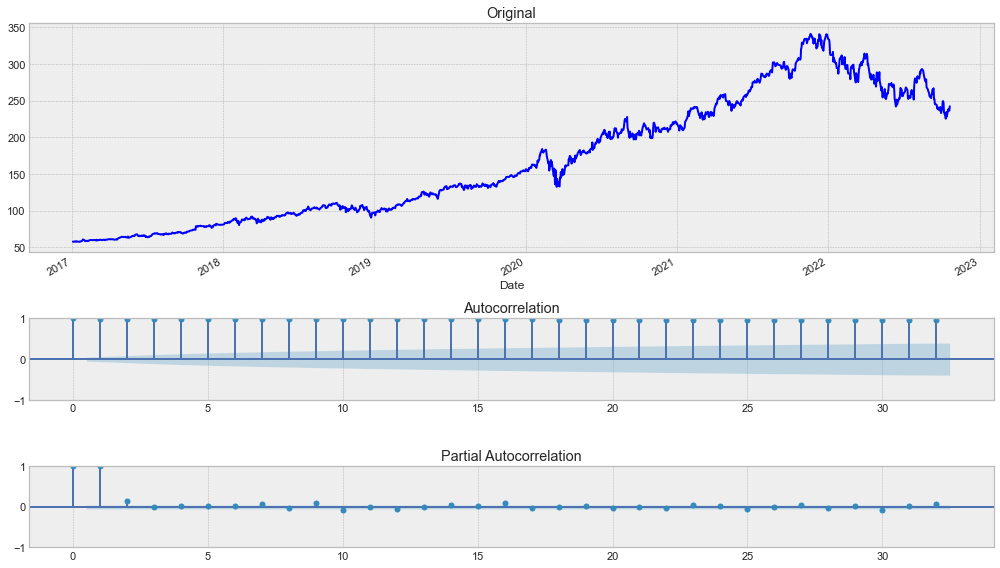

In [282]:
tsplot(df['Close_msft'])
# now p value is above 0.05 so our data is not stationary

Results of Dickey-Fuller Test:
Test Statistic                -1.273478e+01
p-value                        9.210869e-24
#Lags Used                     8.000000e+00
Number of Observations Used    1.452000e+03
Critical Value (1%)           -3.434862e+00
Critical Value (5%)           -2.863533e+00
Critical Value (10%)          -2.567831e+00
dtype: float64


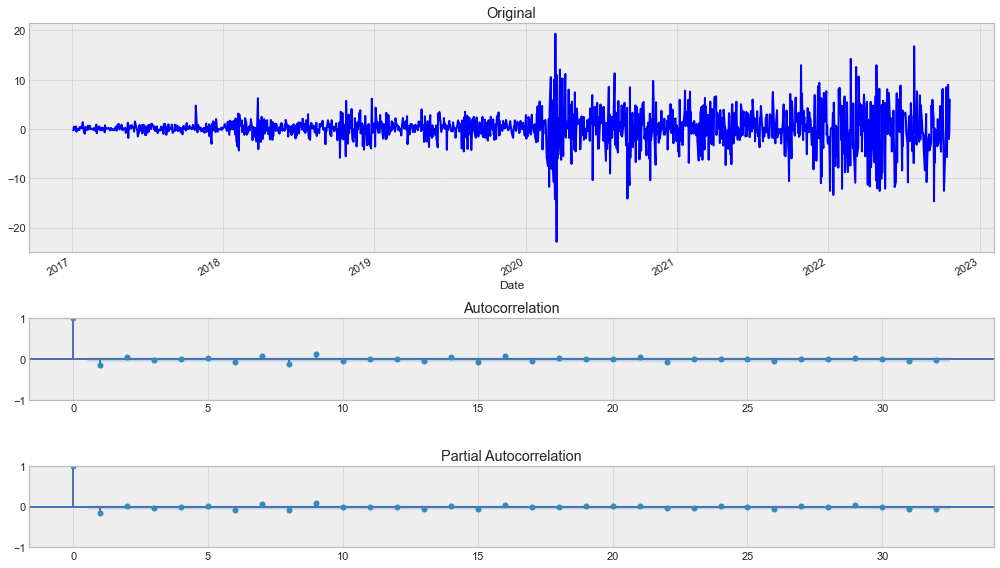

In [283]:
# The data is not stationary so lets use differencing
#diff(1):
df['1st_msft'] = df['Close_msft'].diff(periods=1)
tsplot(df['1st_msft'][1:])

Like this we turned our time series to stationary, since p value for Dickey-Fuller Test is below 0.05. So we can repeat the same process for apple data and make a prediction

***Apple***

Results of Dickey-Fuller Test:
Test Statistic                   -0.636742
p-value                           0.862462
#Lags Used                       22.000000
Number of Observations Used    1439.000000
Critical Value (1%)              -3.434902
Critical Value (5%)              -2.863551
Critical Value (10%)             -2.567840
dtype: float64


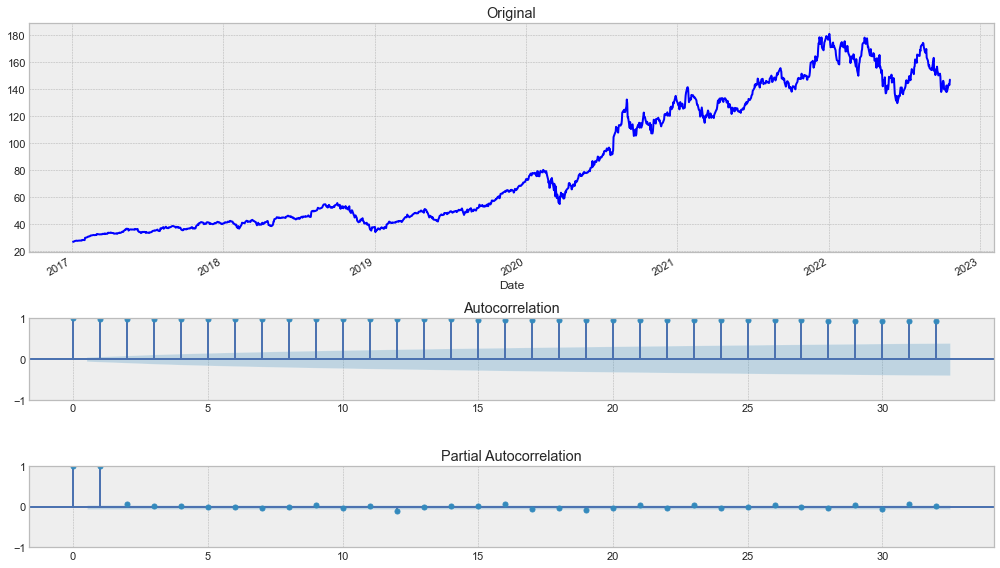

In [284]:
tsplot(df['Close_apple'])
# now p value is above 0.05 so our data is not stationary, like it was for microsoft

Results of Dickey-Fuller Test:
Test Statistic                -7.983439e+00
p-value                        2.586505e-12
#Lags Used                     2.100000e+01
Number of Observations Used    1.439000e+03
Critical Value (1%)           -3.434902e+00
Critical Value (5%)           -2.863551e+00
Critical Value (10%)          -2.567840e+00
dtype: float64


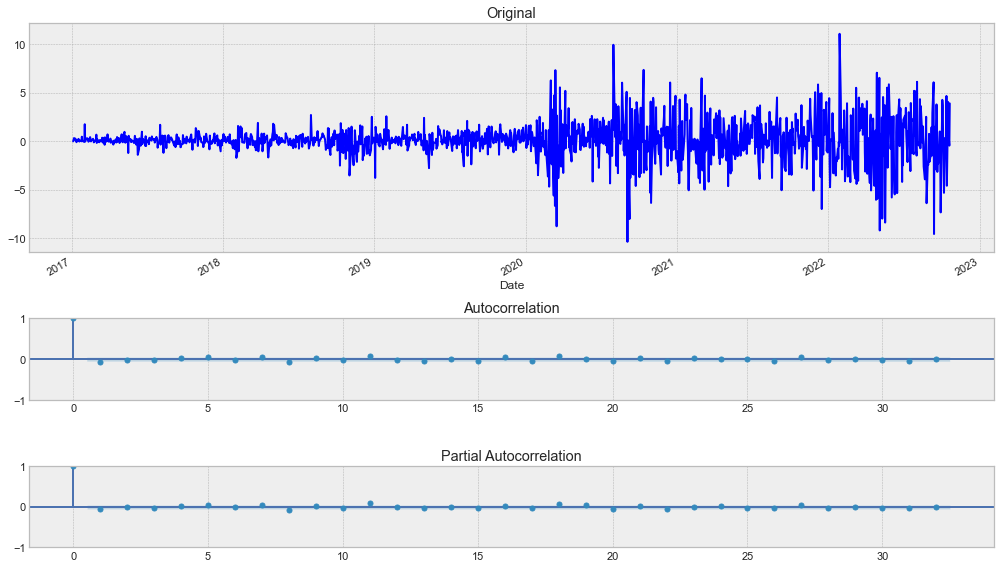

In [285]:
# We use differencing again

df['1st_apple'] = df['Close_apple'].diff(periods=1)
tsplot(df['1st_apple'][1:])

In [234]:
#We can use now ARIMA model to make predictions, since there is no seasonality
# There is an autocorrelation in the data at lag 1
#And we know that we need to use 1st order differencing for data

# Now we use train-test split
Ntest = 253
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [240]:
# RMSE
def rmse(t, y):
    return np.sqrt(np.mean((t-y)**2))




In [245]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train['Close_apple'], order=(1,1,0))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:            Close_apple   No. Observations:                 1209
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2235.688
Date:                Sat, 05 Nov 2022   AIC                           4475.377
Time:                        21:47:33   BIC                           4485.570
Sample:                             0   HQIC                          4479.215
                               - 1209                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1020      0.017     -6.062      0.000      -0.135      -0.069
sigma2         2.3716      0.045     53.248      0.000       2.284       2.459
Ljung-Box (L1) (Q):                   0.01   Jarque-

In [249]:
def plot_fit_and_forecast(result):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(df['Close_apple'], label='data')
    train_pred = result.fittedvalues
    ax.plot(train.index, train_pred, color='grey', label='fitted')

    prediction_result = result.get_forecast(Ntest)
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int['lower Close_apple'], conf_int['upper Close_apple']
    forecast = prediction_result.predicted_mean
    ax.plot(test.index, forecast, label='forecast')
    ax.fill_between(test.index, lower, upper, color='red', alpha=0.3)
    ax.legend()


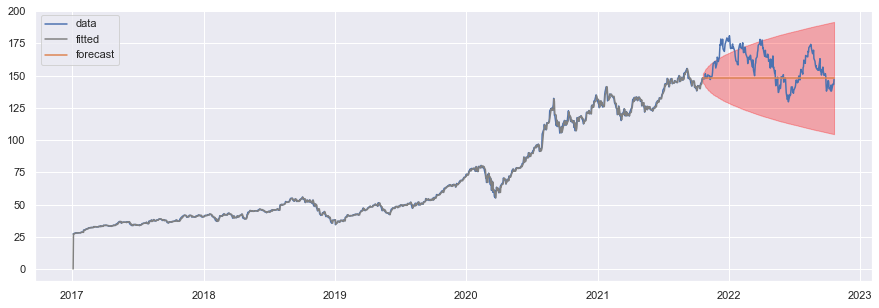

In [250]:
plot_fit_and_forecast(arima_result)

In [255]:
prediction_result = model_fit.get_forecast(Ntest)
forecast = prediction_result.predicted_mean

In [258]:
forecast.head()

1209    148.131837
1210    148.136997
1211    148.136471
1212    148.136525
1213    148.136519
Name: predicted_mean, dtype: float64

In [257]:
def rmse(t, y):
    return np.sqrt(np.mean((t-y)**2))
rmse(test['Close_apple'], forecast)

nan